In [1]:
import os
import sys
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import csv
import pickle
# Display plots inside the notebook:
%matplotlib inline 

In [2]:
# Display plots in external window: 
def show_external(img, cmap=None):
    %matplotlib qt
    plt.imshow(img, cmap)
    plt.show()

In [3]:
def plot_side_by_side(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image)    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image)

In [4]:
# Read in images from folder:
def get_images_from_folder(folder_name='camera_cal'):
    cwd = os.getcwd()
    path = '{}/{}/{}'.format(cwd, folder_name, 'calibration*.jpg')
    image_paths = glob.glob(path)
    images = []
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        images.append(image)
    return images

In [5]:
# # REMOVE
# img = cv2.imread('camera_cal/calibration6.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# print(img.shape)
# #plt.imshow(img)




# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# print(gray.shape)
# plt.imshow(img)

# def binarize(gray, thresh=100):
#     binary = np.zeros_like(gray)
#     binary[:] = gray[:] > thresh           
#     return binary
    
# binary = binarize(gray)
# plt.figure(figsize=(20,10))
# plt.imshow(binary, cmap='gray')
    
        

In [6]:
# # REMOVE
# img = cv2.imread('camera_cal/calibration6.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# print(img.shape)
# #plt.imshow(img)

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# print(gray.shape)
# plt.imshow(img)

# def brighten(gray):
#     brighten = np.copy(gray)
#     brighten_amount = 255 - np.max(brighten)
#     brighten[:] = brighten[:] + brighten_amount           
#     return brighten
    
# brighten = brighten(gray)
# plt.figure(figsize=(20,10))
# plt.imshow(brighten, cmap='gray')
    
        

In [7]:
def calibrate_camera(folder_in='camera_calibration_images', folder_out='camera_calibration_images_output', board_size=(5,9)):
    print('Calibrating', end='')
    nx = board_size[1]
    ny = board_size[0]
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('{}/calibration*.jpg'.format(folder_in))

    # Count the number of images for which corners were found
    num_found = 0
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        print('.', end='')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
       
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            num_found += 1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # Save images with found corners to file
            write_name = 'camera_calibration_images_output/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #plt.imshow(img)
        
            
            
    # Get image size
    # img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration_data = {}
    calibration_data["mtx"] = mtx
    calibration_data["dist"] = dist
    calibration_data["board_size"] = board_size
    pickle.dump(calibration_data, open("calibration_data.p", "wb" ) )
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    if num_found >= 1:
        print('\nCalibration successful')
        print('\nChessboard corners were found on {} of {} images.\n'.format(num_found,len(images)))        
    else:
        print('\nCalibration failed.  Pease try again using different images.') 
    return mtx, dist

In [9]:
# Calibrate camera
mtx, dist = calibrate_camera()

Calibrating.
Calibration successful

Chessboard corners were found on 1 of 1 images.



In [10]:
# Undistort image

# Read in the saved camera matrix and distortion coefficients
calibration_data = pickle.load( open("calibration_data.p", "rb" ) )
mtx = calibration_data["mtx"]
dist = calibration_data["dist"]

# Read in a test image
original_img = cv2.imread('camera_calibration_images/calibration1.jpg')
img = np.copy(original_img)

def undistort(img, mtx, dist):
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

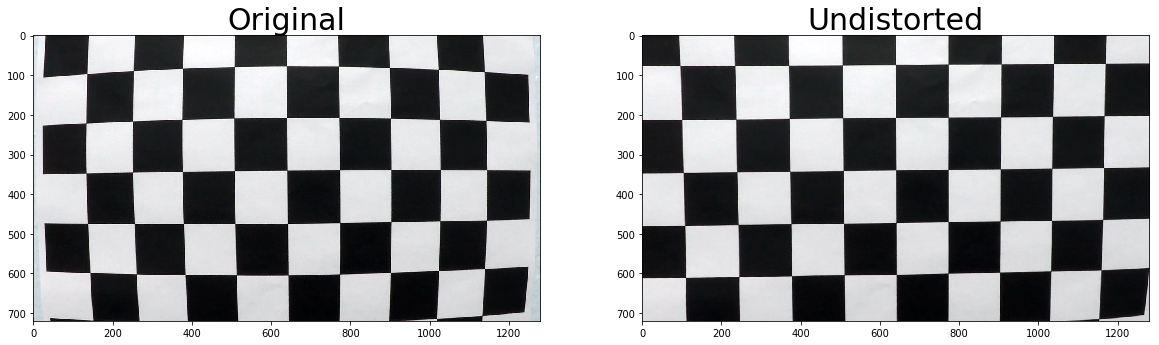

In [11]:
undistorted_image = undistort(img, mtx, dist)
plot_side_by_side(img, undistorted_image, 'Original', 'Undistorted')

In [ ]:
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

In [20]:
# Transform image

# Read in the saved camera matrix and distortion coefficients
calibration_data = pickle.load( open("calibration_data.p", "rb" ) )
mtx = calibration_data["mtx"]
dist = calibration_data["dist"]

# Read in a test image
original_img = cv2.imread('transform_test_image.jpg')
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
img = np.copy(original_img)

# Define src and dst points (x, y) where (origin is top-left: +x is right, +y is down)
# Order: top-left, top-right, bottom-right, bottom-left
src = np.float32(
    [[550, 450],
     [750, 450],
     [1150, 650],
     [150, 650]])
# dst = np.float32(
#     [[850, 320],
#      [850, 320],
#      [850, 320],
#      [850, 320]])

offset = 100 # offset for dst points

def perspective_transform(img, src, offset):


    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here

    # Grab the image shape (width (pos-right), height (pos-down))
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
    # Order: top-left, top-right, bottom-right, bottom-left
    # src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [19]:
# show_external(img)

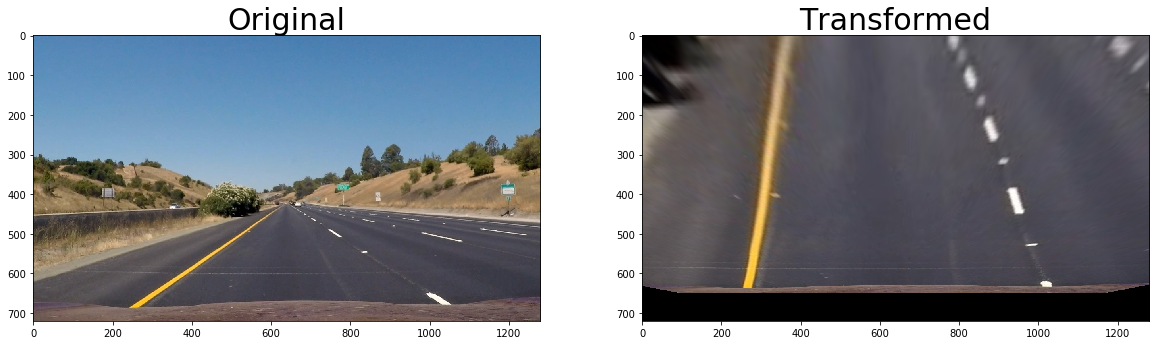

In [22]:
warped_image = perspective_transform(img, src, offset)
plot_side_by_side(img, warped_image ,'Original' , 'Transformed')

In [ ]:
# # Perspective Transform

# # Read in the saved camera matrix and distortion coefficients
# # These are the arrays you calculated using cv2.calibrateCamera()
# dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
# mtx = dist_pickle["mtx"]
# dist = dist_pickle["dist"]

# # Read in an image
# img = mpimg.imread('calibration_wide/GOPR0060.jpg')
# nx = 8 # the number of inside corners in x
# ny = 6 # the number of inside corners in y

# # MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# # THAT LOOKS LIKE THE IMAGE ABOVE
# def corners_unwarp(img, nx, ny, mtx, dist):
#     # Use the OpenCV undistort() function to remove distortion
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
#     # Convert undistorted image to grayscale
#     gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
#     # Search for corners in the grayscaled image
#     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#     if ret == True:
#         # If we found corners, draw them! (just for fun)
#         cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
#         # Choose offset from image corners to plot detected corners
#         # This should be chosen to present the result at the proper aspect ratio
#         # My choice of 100 pixels is not exact, but close enough for our purpose here
#         offset = 100 # offset for dst points
#         # Grab the image shape
#         img_size = (gray.shape[1], gray.shape[0])

#         # For source points I'm grabbing the outer four detected corners
#         src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#         # For destination points, I'm arbitrarily choosing some points to be
#         # a nice fit for displaying our warped result 
#         # again, not exact, but close enough for our purposes
#         dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                                      [img_size[0]-offset, img_size[1]-offset], 
#                                      [offset, img_size[1]-offset]])
#         # Given src and dst points, calculate the perspective transform matrix
#         M = cv2.getPerspectiveTransform(src, dst)
#         # Warp the image using OpenCV warpPerspective()
#         warped = cv2.warpPerspective(undist, M, img_size)

#     else:
#         warped, M = None, None
        
#     # Return the resulting image and matrix
#     return warped, M

# warped, M = corners_unwarp(img, nx, ny, mtx, dist)

